Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---

## Introduction to ANN - PyTorch Exercise
---
Instructions are given in <span style="color:blue">blue</span> color.

## Overview
- [Task 1: Train a model for Fashion MNIST](#Task-1:-Train-a-model-for-Fashion-MNIST)
  - [Task 1.1: Import helper functions](#Task-1.1:-Import-helper-functions)
  - [Task 1.2: Use FashionMNIST](#Task-1.2:-Use-FashionMNIST)
  - [Task 1.3: Create a model and use the appropriate device](#Task-1.3:-Create-a-model-and-use-the-appropriate-device)
  - [Task 1.4: Train the model](#Task-1.4:-Train-the-model)
  - [Task 1.5: Check model quality](#Task-1.5:-Check-model-quality)
- [Task 2: Use the model for inference](#Task-2:-Use-the-model-for-inference)
  - [Task 2.1: Inference and visualization](#Task-2.1:-Inference-and-visualization)
  - [Task 2.2: Challenge - visualizing misclassifications](#Task-2.2:-Challenge---visualizing-misclassifications)

---

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# for timing
import datetime as dt

## Task 1: Train a model for Fashion MNIST
In the first part of the exercise, we want to train a model we can use for `FashionMNIST` and get an ideas as to how well it performs.

### Task 1.1: Import helper functions
<span style="color:blue">
    In contrast to what we did in the material notebook, please use the helper functions for the training loop by importing them<br>
    <b>Hint:</b> The helper functions are provided in the script <code>train_loop.py</code>
</span>

In [36]:
# helper functions for the training loop
from train_loop import train, validate, plot_history, train_for_epochs


ImportError: cannot import name 'predict_batch' from 'train_loop' (c:\Users\smart\Documents\SMax Code\Python\Deep learning in Machine vision\Exercise\Introduction to Artificial Neural Networks\train_loop.py)

### Task 1.2: Use FashionMNIST
<span style="color:blue">
Instead of the usual MNIST dataset, use the drop-in replacement <a href=https://github.com/zalandoresearch/fashion-mnist>FashionMNIST</a>.<br>
    <b>Hint:</b> Like the MNIST dataset, <code>FashionMNIST</code> is also directly available from the <code>torchvision.datasets</code> module. Thus, not much has to be changed here ...
</span>

In [8]:
# Download training data and test data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:00<00:00, 62170810.48it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 7381484.86it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 56258500.84it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 6298797.26it/s]


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [10]:
BATCH_SIZE = 64

# Create data loaders.
train_dataloader =  DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


--------------




### Task 1.3: Create a model and use the appropriate device
<span style="color:blue">
Make sure you create a neural network and use powerful hardware if available. Do you have to modify anything compared with the material notebook here?
</span>

In [11]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
USE_GPU = True
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weights to the desired device
model = NeuralNetwork().to(device)
model

Using cuda for training the network


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

--------------




### Task 1.4: Train the model
<span style="color:blue">
    Now train the model for 10 epochs as in the MNIST case. Be sure to specify a <code>criterion</code> and an <code>optimizer</code> and record
    the time needed for training.
</span>

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [17]:
NUM_EPOCHS = 10

# perform training
start_train_mnist = dt.datetime.now()
print(f'MNIST training started: {start_train_mnist}')

history = train_for_epochs(device, NUM_EPOCHS, model, train_dataloader,
                 test_dataloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

MNIST training started: 2024-04-28 15:42:03.116599


  0%|          | 0/10 [00:00<?, ?it/s]

MNIST training finished: 2024-04-28 15:43:37.520191 (duration: 0:01:34.403592)


### Task 1.5: Check model quality
<span style="color:blue">
    Check how well the final model performs and plot the development of the quality criteria over the epochs.
</span>

In [18]:
# accuracy on the training as well as the test data
train_acc = history['train']['accuracy'][-1]
val_acc = history['val']['accuracy'][-1]
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}')


Train Acc. 73.79
Val Acc. 73.18


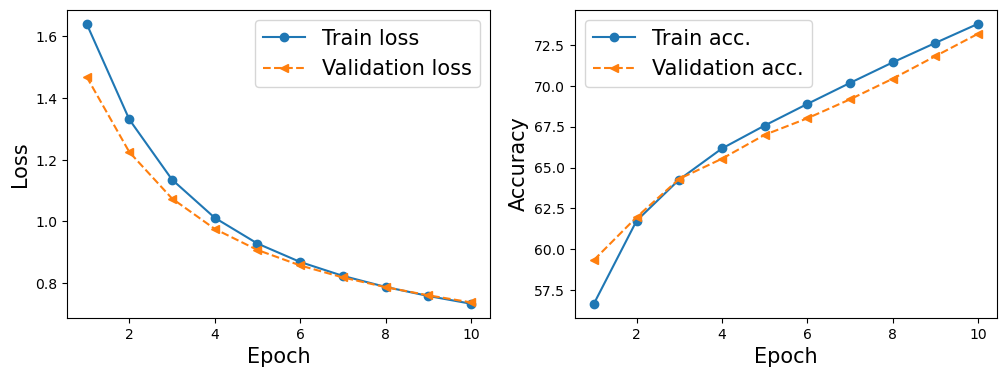

In [19]:
# plot training history
plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])

<span style="color:blue">
    Interpret the current status. Are you sattisfied with the result?
</span>

**Interpretation** ...

--------------
<div style="color:lightblue"> The models accuracy is acceptable, as it is quite accurate for both the training and the testing data, but both the loss and the accuracy are going up, so maybe as we train it more, we might get better results

In [20]:
NUM_EPOCHS = 30

# perform training
start_train_mnist = dt.datetime.now()
print(f'MNIST training started: {start_train_mnist}')

history = train_for_epochs(device, NUM_EPOCHS, model, train_dataloader,
                 test_dataloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

MNIST training started: 2024-04-28 15:47:34.288677


  0%|          | 0/30 [00:00<?, ?it/s]

MNIST training finished: 2024-04-28 15:52:22.435532 (duration: 0:04:48.146855)


In [22]:
train_acc = history['train']['accuracy'][-1]
val_acc = history['val']['accuracy'][-1]
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}')


Train Acc. 83.41
Val Acc. 82.10


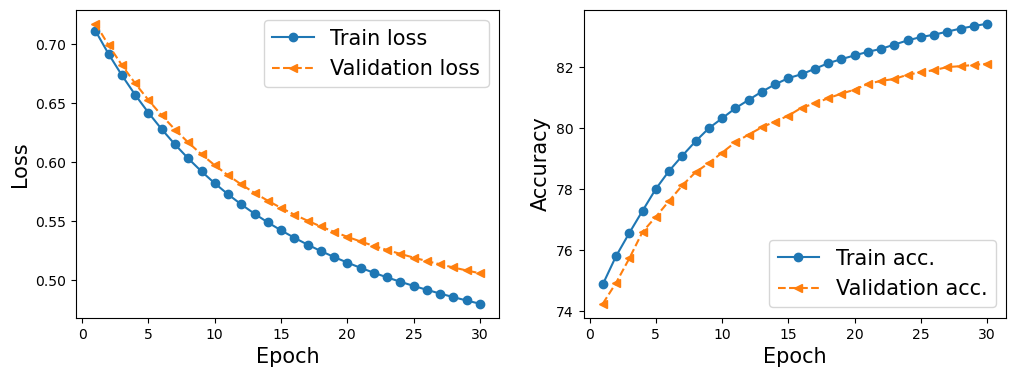

In [25]:
# plot training history
plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])
plt.show()

<div style="color:lightblue"> after training the model for 30 more epochs, we see that the accuracy for both sets of data improves by around 10% and the loss value goes down, so the model would benifit from more training, up to a certian point, where it would presumably reach a plateau

## Task 2: Use the model for inference
Once the model has been trained, we want to use it to classify new images. Ideally, we have an appropriate way of visualizing the results.

### Task 2.1: Inference and visualization
<span style="color:blue">
    Now apply the model 
    <ul>
        <li>to a single image </li>
        <li>to 16 images of a batch provided by the test data loader</li>
    </ul>
    Then visually check the predictions vs. the actual classes for those 16 elements (be sure to arrange the images in a 4 x 4 grid when doing so)<br>
    <b>Hint:</b> The numbers of the classes represent actual items this time. You will therefore need to use a list which <i>maps</i> the numbers to the actual items. You can find the mapping <a href=https://github.com/zalandoresearch/fashion-mnist#Labels>here</a>.
</span>

In [34]:
classes = range(10)
class_lab = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

model.eval()
x, y = test_data[55][0], test_data[55][1]
with torch.no_grad(): # no info for backward pass needed
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}({class_lab[predicted]})", Actual: "{actual}({class_lab[actual]})"')

Predicted: "2(Pullover)", Actual: "2(Pullover)"


In [40]:
# test on first 16 images of the first set
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()
    
batch_test = next(iter(test_dataloader))

preds, _ = predict_batch(model, batch_test[0][:16], binary=False)

print(preds)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1])


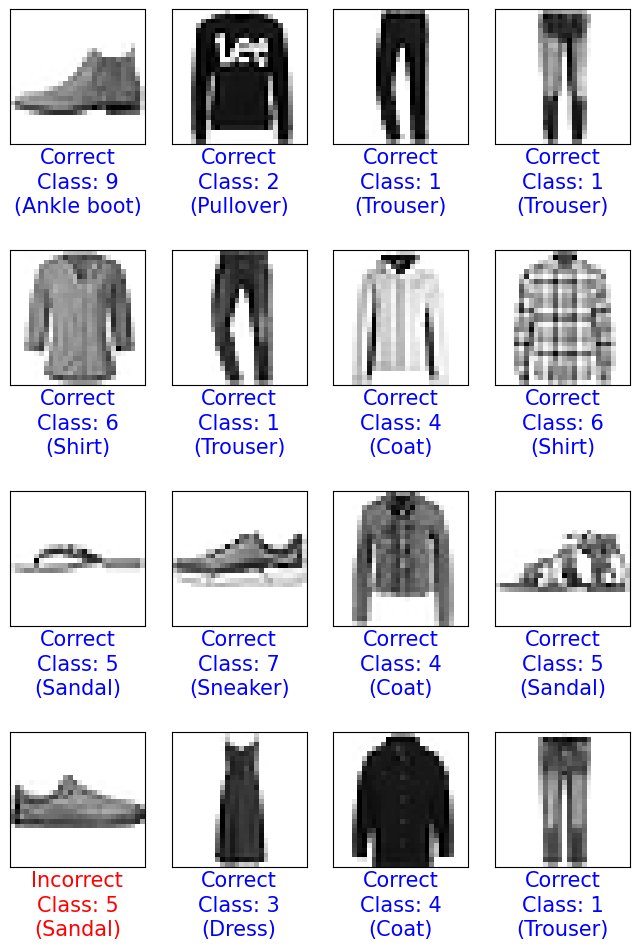

In [102]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 12))
    for i in range(16):
        correct = preds[i] == batch_test[1][i]
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.5, -0.2, '{}'.format(f"\n\nClass: {preds[i]}\n({class_lab[int(preds[i])]})"), 
                size=15, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.5, -0.1, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=15, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

---

### Task 2.2: Challenge - visualizing misclassifications
<span style="color:blue">
    Find all misclassifications and visualize some of them.
</span>

In [94]:
# load all test data
test_dataloader_all = DataLoader(test_data, batch_size=10000)

In [133]:
batch_test = next(iter(test_dataloader_all))

preds, _ = predict_batch(model, batch_test[0][:], binary=False)


print(f"Number of mispredicted elements: {len(miss_preds)}")

Number of mispredicted elements: 1790


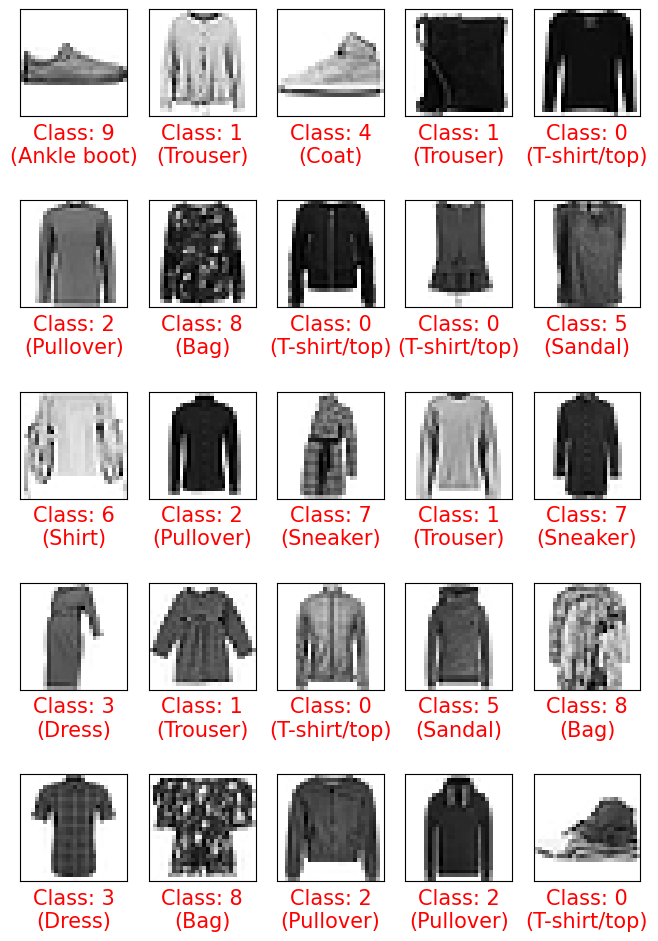

In [128]:
#plot 25 misspredictions in

with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 12))
    for ij in range(25):
        i = ij*5
        ax = fig.add_subplot(5, 5, ij+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = miss_preds[i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.5, -0.05, '{}'.format(f"\n\nClass: {preds[i]}\n({class_lab[int(preds[i])]})"), 
                size=15, color='red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)

plt.show() 